## Library Import

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

## Prepare the CIFAR-10 Data

In [ ]:
# Prepare the cifar-10 dataset

root = "/home/shashank/tensorflow_datasets/downloads/cifar10_ds"
y = []
X = []
map = {}

for (idx, category) in enumerate(os.listdir(root)):
    map[category] = idx
    image_count = 0
    for img_file in os.listdir(os.path.join(root, category)):        
        
        img = Image.open(os.path.join(root, category, img_file))
        img_array = np.array(img).flatten() / 255.0
        
        X.append(img_array)
        y.append(map[category])
        
        image_count += 1
        if image_count == 500:
            break

In [ ]:
X = np.asarray(X)
y = np.asarray(y)

# shuffle the images
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# one hot encoded
y = np.eye(10)[y]

## Training with different optimizers

In [73]:
def softmax(x, axis=-1):
    x_shifted = x - np.max(x, axis=axis, keepdims=True)  # prevent large exponents
    e_x = np.exp(x_shifted)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def loss(y, y_pred, eps=1e-4):
    loss_ = -np.mean(y*np.log(y_pred+eps))
    return loss_

In [ ]:
def optimizer(W1, W2, optim, epochs=1000, lr=0.001, eps=1e-8):

    loss_list = []

    for i in range(epochs):
        
        if optim["type"] == "nesterov":
            
            W1 -= optim["momentum"] * optim["velocity_dw1"]
            W2 -= optim["momentum"] * optim["velocity_dw2"]

        # forward pass
        X1 = np.matmul(X, W1) # (N, 64)
        X2 = np.maximum(X1, 0) # (N, 64)
        X3 = np.matmul(X2, W2) # (N, 10)

        y_pred = softmax(X3) # (N, 10)

        L = loss(y, y_pred)
        
        loss_list.append(L)

        # backward pass

        # dL/dW1 = dL/dy_pred * dy_pred/dX3 * dX3/dX2 * dX2/dX1 * dX1/dW1
        # dL/dW1 = (y_pred - y_true) * dX3/dX2 * dX2/dX1 * dX1/dW1
        # dL/dW1 = (y_pred - y_true) @ W2.T * dX2/dX1 * dX1/dW1
        # dL/dW1 = X.T @ (y_pred - y_true) @ W2.T * (X1>0) 

        dL_by_dW1 = (X.T @ (((y_pred - y) @ W2.T) * (X1>0))) / len(y)
        dL_by_dW2 = (X2.T @ (y_pred - y)) / len(y)
        
        if optim["type"] == "adagrad":
            
            optim["cache_dw1"] += dL_by_dW1**2
            optim["cache_dw2"] += dL_by_dW2**2
            
            W1 -= lr*dL_by_dW1 / (np.sqrt(optim["cache_dw1"]) + eps)
            W2 -= lr*dL_by_dW2 / (np.sqrt(optim["cache_dw2"]) + eps)
        
        elif optim["type"] == "rmsprop":
            optim["cache_dw1"] = optim["decay"]*optim["cache_dw1"] + (1-optim["decay"])*dL_by_dW1**2
            optim["cache_dw2"] = optim["decay"]*optim["cache_dw2"] + (1-optim["decay"])*dL_by_dW2**2
            
            W1 -= lr*dL_by_dW1 / (np.sqrt(optim["cache_dw1"]) + eps)
            W2 -= lr*dL_by_dW2 / (np.sqrt(optim["cache_dw2"]) + eps)
        
        elif optim["type"] == "adam":
            
            optim["m_dw1"] = optim["b1"]*optim["m_dw1"] + (1-optim["b1"])*dL_by_dW1
            optim["m_dw2"] = optim["b1"]*optim["m_dw2"] + (1-optim["b1"])*dL_by_dW2
            
            optim["v_dw1"] = optim["b2"]*optim["v_dw1"] + (1-optim["b2"])*dL_by_dW1**2
            optim["v_dw2"] = optim["b2"]*optim["v_dw2"] + (1-optim["b2"])*dL_by_dW2**2
            
            W1 -= lr*optim["m_dw1"] / (np.sqrt(optim["v_dw1"]) + eps)
            W2 -= lr*optim["m_dw2"] / (np.sqrt(optim["v_dw2"]) + eps)
        
        elif optim["type"] == "nesterov":
            
            optim["velocity_dw1"] = optim["momentum"] * optim["velocity_dw1"] + lr*dL_by_dW1
            optim["velocity_dw2"] = optim["momentum"] * optim["velocity_dw2"] + lr*dL_by_dW2
            
            W1 -= lr*dL_by_dW1
            W2 -= lr*dL_by_dW2
        
        elif optim["type"] == "sgd" and optim["momentum"]:
            
            optim["velocity_dw1"] = optim["momentum"] * optim["velocity_dw1"] + lr*dL_by_dW1
            optim["velocity_dw2"] = optim["momentum"] * optim["velocity_dw2"] + lr*dL_by_dW2
            
            W1 -= optim["velocity_dw1"]
            W2 -= optim["velocity_dw2"]
        
        elif optim["type"] == "sgd":

            W1 -= lr*dL_by_dW1
            W2 -= lr*dL_by_dW2
        
    return loss_list

In [ ]:
epochs = 1000

# Dense(64)
W1 = np.random.randn(3072, 64) 

# Dense(10)
W2 = np.random.randn(64, 10)

### SGD

In [ ]:
optim = {"type": "sgd",
         "momentum":0,
         }

sgd_loss = optimizer(W1.copy(), W2.copy(), optim, epochs=1000, lr=0.001)

### SGD with Momentum

In [78]:
optim = {"type": "sgd",
         "momentum":0.9,
         "velocity_dw1": 0,
         "velocity_dw2": 0
         }

sgd_momentum_loss = optimizer(W1.copy(), W2.copy(), optim, epochs=1000, lr=0.001)

### Nesterov

In [79]:
optim = {"type": "nesterov",
         "momentum":0.9,
         "velocity_dw1": 0,
         "velocity_dw2": 0
         }

nesterov_loss = optimizer(W1.copy(), W2.copy(), optim, epochs=1000, lr=0.001)

### Adagrad

In [80]:
optim = {"type": "adagrad",
         "cache_dw1": 0,
         "cache_dw2": 0
         }

adagrad_loss = optimizer(W1.copy(), W2.copy(), optim, epochs=1000, lr=0.001)

### RMSProp

In [81]:
optim = {"type": "rmsprop",
         "cache_dw1": 0,
         "cache_dw2": 0,
         "decay":0.999
         }

rmsprop_loss = optimizer(W1.copy(), W2.copy(), optim, epochs=1000, lr=0.001)

### Adam

In [82]:
optim = {"type": "adam",
         "m_dw1": 0,
         "m_dw2": 0,
         "v_dw1": 0,
         "v_dw2": 0,
         "b1":0.9,
         "b2":0.99
         }

adam_loss = optimizer(W1.copy(), W2.copy(), optim, epochs=1000, lr=0.001)

## Comparison

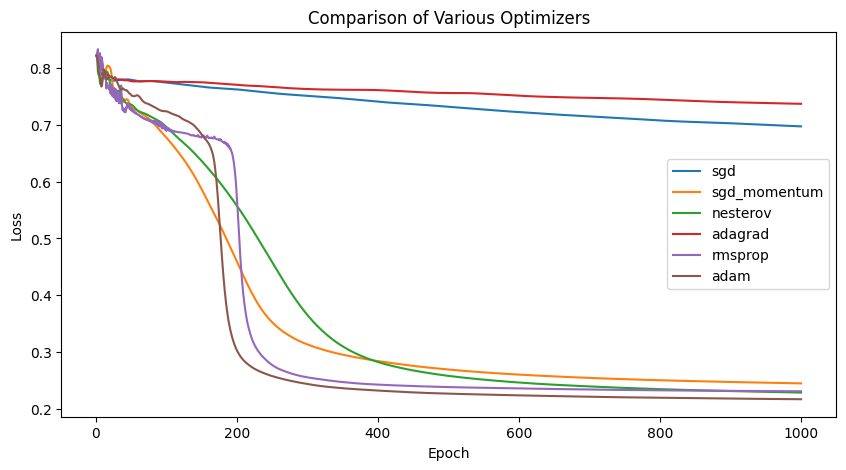

In [83]:
plt.figure(figsize=(10, 5)) 
plt.plot(np.linspace(1, epochs, epochs), sgd_loss, label="sgd")
plt.plot(np.linspace(1, epochs, epochs), sgd_momentum_loss, label="sgd_momentum")
plt.plot(np.linspace(1, epochs, epochs), nesterov_loss, label="nesterov")
plt.plot(np.linspace(1, epochs, epochs), adagrad_loss, label="adagrad")
plt.plot(np.linspace(1, epochs, epochs), rmsprop_loss, label="rmsprop")
plt.plot(np.linspace(1, epochs, epochs), adam_loss, label="adam")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Comparison of Various Optimizers")
plt.show()